In [1]:
from reservoir_rls_multires import *
import matplotlib.pyplot as plt
from lorenz63 import *
from scipy.signal import welch, periodogram
from tqdm import tqdm
import cma

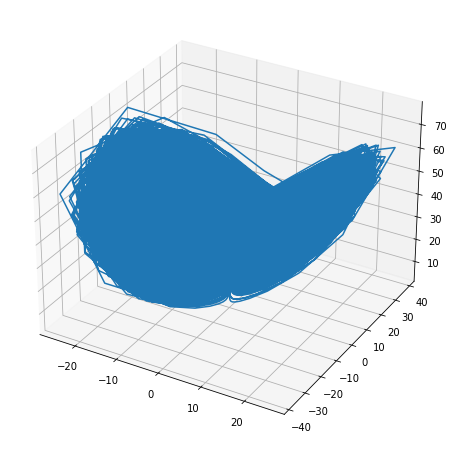

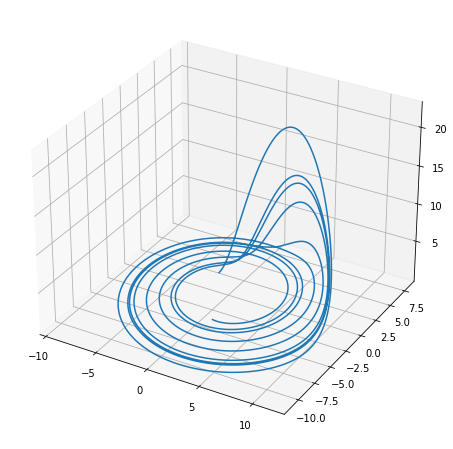

In [2]:
data_length = 500000
step = 0.05
f_s = 1/step
scale = 0.01
slow_var = 48/28
r_t = lambda x: r_t_const(x)
dx_dt = lambda x, time, r_t: dxdt_lorenz_rossler(x, time, r_t, scale = scale, slow_var = slow_var)
lorenz_data_rossler = getCoupledLorenzData(data_length, r_t, dx_dt, sample_tau = step)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111,projection = '3d')
ax.plot3D(lorenz_data_rossler[:,0],lorenz_data_rossler[:,1],lorenz_data_rossler[:,2])
plt.show()
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111,projection = '3d')
ax.plot3D(lorenz_data_rossler[:,3],lorenz_data_rossler[:,4],lorenz_data_rossler[:,5])
plt.show()
scaled_data = lorenz_data_rossler[:,:3]
scaled_data = np.ascontiguousarray(scaled_data)

In [11]:
num_nodes = 300
num_tests = 100
train_length = 1000
sync_length = 500
pred_length = 500
res_seed = 1
base_res = reservoir(3,num_nodes,input_weight = 1, spectral_radius = 1, seed = res_seed) #Generate a reservoir
mask = ['input_weight', 'regularization']
x0 = np.array([5.25,5])
# Set the minimization function. This function takes num_tests training
# and validation data sets and trains the reservoir to predict each validation set
# after being trained on the corresponding training set. The negative median valid
# time is returned to be minimized.
min_func = lambda x: vt_min_function_norm(scaled_data, x, mask, base_res.Win, base_res.A, \
     num_tests = num_tests,  num_nodes = num_nodes, pred_length = pred_length, train_length = train_length)
sigma = 2

In [12]:
opts = cma.CMAOptions()
opts.set('popsize',6*x0.size) # Set number of samples per generation
"""
Set bounds on parameters. IMPORTANT: The mean returned by cma-es is
the mean BEFORE the boundary function is applied, so the mean may not
lie in the domain set by bounds. To obtain the true sample mean requires 
downloading the cma-es package from github and editing one of the 
functions. Ask me if you need to do this.
"""
opts.set('bounds', [0,10]) 
opts.set('seed', 5) # Seed for the initial samples
"""
File where results are saved. IMPORTANT: Full covariance matrix is 
NOT saved, nor are the exact samples. If these need to be saved, one
will also have to download from github and make some edits. Again,
ask me.
"""
opts.set('verb_filenameprefix','cmaes_lorenz_rossler_norm_4vars_res%d\\' % res_seed)
results = cma.fmin(min_func, x0, sigma, options = opts) # Run the algorithm

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 2 (seed=5, Tue Dec 15 13:37:29 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 -1.700000000000000e-01 1.0e+00 2.06e+00  2e+00  2e+00 0:51.2
    2     24 -1.700000000000000e-01 1.4e+00 1.78e+00  2e+00  2e+00 1:43.4
    3     36 -1.700000000000000e-01 1.4e+00 1.47e+00  1e+00  2e+00 2:36.7
    4     48 -1.700000000000000e-01 1.4e+00 2.46e+00  2e+00  3e+00 3:29.5
    5     60 -1.700000000000000e-01 1.5e+00 4.72e+00  4e+00  6e+00 4:22.6
    6     72 -1.900000000000000e-01 1.8e+00 8.80e+00  7e+00  1e+01 5:14.3
    7     84 -1.900000000000000e-01 2.0e+00 1.09e+01  8e+00  1e+01 6:05.8
    8     96 -1.900000000000000e-01 2.6e+00 9.58e+00  6e+00  1e+01 6:57.3
    9    108 -1.900000000000000e-01 3.3e+00 8.95e+00  5e+00  1e+01 7:49.2
   10    120 -2.000000000000000e-01 4.3e+00 9.28e+00  4e+00  1e+01 8:41.0
   11    132 -1.900000000000000e-01 4.6e+00 1.05e+01  4e+00  1e+01 9:32.6
   12    144 -1.900000000000